# Strategies
A _strategy_ is an object that decides, for given MDP and history of a play, what is the next action to play. A _history_ is a sequence $s_1a_1s_2a_2\ldots s_n$ of states and actions, where each action $a_i$ is an action available in the state $s_i$, and $s_{i+1}$ is a possible outcome of $a_i$. In FiMDP, the strategy is responsible for maintaining the histories of plays. This is achieved as follows.
 1. Strategy is initialized for a new play (at least the initial state of the play), 
 2. strategy picks the next action to play (and can remember it), and
 3. the actual outcome of the picked action is communicated to the strategy.
 
The initialization happens only once and then only the steps 2. and 3. alternate.

## Interface for strategies
We demonstrate the interface for strategies using the following little example

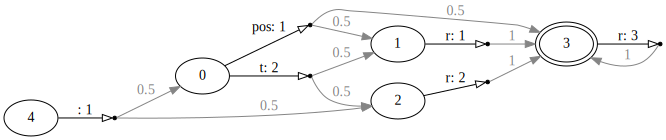

In [1]:
from fimdp.examples.reachability_examples import little_alsure2
mdp, _ = little_alsure2(); mdp

A `strategy` is an object that offers the following 3 functions:
 * `strategy.reset(init_state=None, *args, **kwargs)` is a function that initializes the strategy for a new play and it is, by default, called at the creation of the object, 
 * `strategy.next_action()` picks an action based
on the history, and the function 
 * `strategy.update_state(outcome)` tells the
strategy that the last action picked was resolved to the state outcome. 

`PickFirstStrategy` is class of such objects. It implements a very simple type of strategies that ignore the energy and always returns the action, that is the first available for the current state. Of course, such strategy does not offer any guarantees and serves only for demonstration purposes. We create one such object and initialize it to start a new play in state `4`.

In [2]:
from fimdp.core import PickFirstStrategy
pfs = PickFirstStrategy(mdp=mdp, init_state=4)
pfs.next_action()

4——[1]——>{0: 0.5, 2: 0.5}

The actions are represented by `source_state--label[cost]-->outcomes_distribution`. You can see that the source state of the action is `4` as expected. The action has two possible outcomes:
 * the state `0` with probability `0.5`, and
 * the state `2` with probability `0.5`.

We can now tell the strategy that the action was resolved to `0` and ask for next action.

In [3]:
pfs.update_state(0)
pfs.next_action()

0——t[2]——>{1: 0.5, 2: 0.5}

To enforce consistent histories, each call to `next_action` should be
followed by a call to `update_state` and vice versa. Both functions raise
`WrongCallOrderError` if the calls do not alternate. The reason is obvious: the strategy cannot pick a new action until it knows in which state of the MDP the play is. The following call to `next_action()` raises, as expected, the `WrongCallOrderError`.

In [4]:
pfs.next_action()

WrongCallOrderError: The outcome of the last action is not known. Supply it using the `outcome` parameter or using the function`strategy.update_state(outcome)`.

In the next cell, only the second call raises the error and only the first update is recorded.

In [5]:
pfs.update_state(1)
pfs.update_state(2)

WrongCallOrderError: `strategy.update_state()` must be called after `strategy.next_action()`.

The `strategy._current_state` stores the last state of the history. As stated before, only the first call of `update_state` was recorded and the state is 1.

In [6]:
print(pfs._current_state)
pfs.next_action()

1


1——r[1]——>{3: 1}

To simplify code, `strategy.next_action(outcome)` is a shorthand for

```python
strategy.update_state(outcome)
strategy.next_action()
```

In [7]:
pfs.next_action(3)

3——r[3]——>{3: 1}

The function `update_state(outcome)` (as well as `next_action(outcome)`) raises a `ValueError` if `outcome` is
not a valid successor for the last action returned by `next_action()`. Based
on the `outcome`, the strategy can update its memory (for example, append `outcome` to its history).

In [8]:
pfs.update_state(1)

ValueError: The outcome 1 is not a valid successor for the last action picked by this strategy. The list of possible outcomes is [3].

The strategy can be used in a new play using `strategy.reset()` which allows erasing and new initialization of memory, if any, and changing the current state without any checks for consistency with the previous action. If the `init_state` is not given at the time of initialization of the object, `update(outcome)` or `next_action(outcome)` must be called first. Otherwise, `next_action()` should be the first in the sequence. The two following sequences of calls are equivalent and both start a new play in state `2`.

In [9]:
pfs.reset()
pfs.next_action(2)

2——r[2]——>{3: 1}

In [10]:
pfs.reset(2)
pfs.next_action()

2——r[2]——>{3: 1}

## Counter strategies

Counter strategies, analogous to those described in our [CAV paper], are implemented in `fimdp.strategy.CounterStrategy`. They keep track of the energy of the play in its memory (track consumption and reloading) and picks the actions to play based on the current state (the last state of the history) and energy. The main ingredient of a counter strategy is a [counter selector](#Counter-selectors). Counter selectors are the objects returned by [Energy solvers].

[Energy solvers]: Solvers.ipynb
[CAV paper]: https://link.springer.com/chapter/10.1007/978-3-030-53291-8_22

In [11]:
from fimdp.examples.reachability_examples import ultimate
from fimdp.energy_solvers import BasicES, BUCHI
m, T = ultimate()
solver = BasicES(m, cap=40, targets=T)
m.energy_levels = solver
selector = solver.get_selector(BUCHI)
type(selector)

fimdp.strategy.CounterSelector

### Using counter strategies
A `CounterStrategy` needs to be initialized with the `mdp` object, with a `selector`, _initial energy level_, and _capacity_ (and possibly an _initial state_ like all strategies). It is an energy-aware strategy which expects that the energy is replenished to full capacity in reload states.

We will use the mdp `m` from the previous cell and the `selector` generated by the Basic energy solver for Büchi objective. The green numbers in each state in the following figure show the minimal levels of energy needed to satisfy the Büchi objective with the blue states as target states (`T`).

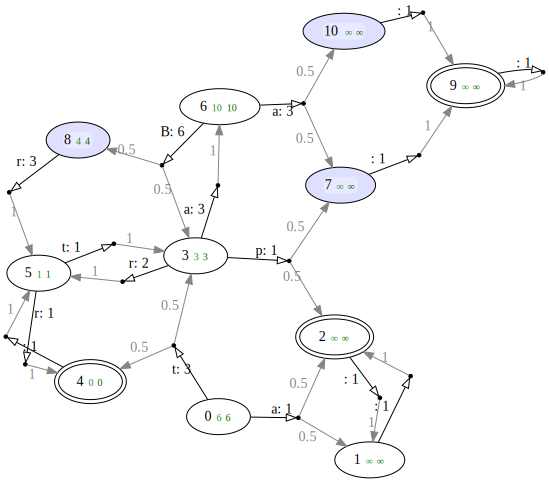

In [12]:
m

Let's see a play that starts from `6` with the minimal energy needed: `10`. Because we started with the minimal energy needed, the first visit to state `3` is resolved to action labeled `r` (as reload) and that leads toward the reload state 4.

In [13]:
from fimdp.core import CounterStrategy
strategy = CounterStrategy(m, selector, 40, 10, init_state=6)
print(f"Current energy at state {strategy._current_state}: {strategy.energy}")
strategy.next_action()
strategy.next_action(3)

Current energy at state 6: 10


3——r[2]——>{5: 1}

At the first visit to the state `5`, the strategy picks the action that goes to `4`. We can see that `strategy` automatically increases the level of energy after reloading when leaving the state `4`. The next visit to `5` is with more energy and the strategy thus picks the action leading to `3`.

In [14]:
strategy.update_state(5)
print(f"Current energy at state {strategy._current_state}: {strategy.energy}")
print(strategy.next_action())
strategy.update_state(4)
print(f"Current energy at state {strategy._current_state}: {strategy.energy}")
print(strategy.next_action())
strategy.update_state(5)
print(f"Current energy at state {strategy._current_state}: {strategy.energy}")
strategy.next_action()

Current energy at state 5: 2
5——r[1]——>{4: 1}
Current energy at state 4: 1
4——[1]——>{5: 1}
Current energy at state 5: 39


5——t[1]——>{3: 1}

Similarly, the next action picked at the state `3` will lead to `6` and new attempt to reach `8` can happen from there.

In [15]:
print(strategy.next_action(3))
print(strategy.next_action(6))

3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}


The states `6` and `3` can alternate, until the energy level drops below 13 at `3`, or the play goes to `8`.

In [16]:
strategy.update_state(3)
print(f"Energy: {strategy.energy}, action: {strategy.next_action()}")
print(strategy.next_action(6))
strategy.update_state(3)
print(f"Energy: {strategy.energy}, action: {strategy.next_action()}")
print(strategy.next_action(6))
strategy.update_state(3)
print(f"Energy: {strategy.energy}, action: {strategy.next_action()}")

Energy: 29, action: 3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
Energy: 20, action: 3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
Energy: 11, action: 3——r[2]——>{5: 1}


#### Reseting
To start a new play, we have to initialize `CounterStrategy` objects with the initial energy level (the selector and capacity remain the same).

In [17]:
strategy.reset(init_energy=10)
strategy.next_action(6)

6——B[6]——>{3: 0.5, 8: 0.5}

### Counter selectors
Counter selector is basically a function from MDP states to [selection rules](#Selection-rules). They select actions based on given state and energy level. The implementation in the class `fimdp.strategy.CounterSelector` is a list of `SelectionRule`s extended by:
 * pointer to the corresponding mdp, and
 * 2 functions for updating and accessing actions to be taken:
   - update(state, energy_level, action)
   - select_action(state, energy)
 * and a function to copy values from another `CounterSelector`
   - copy_values_from(other, state_subset)

In [18]:
selector

[{16: 0——t[3]——>{3: 0.5, 4: 0.5}, 6: 0——t[3]——>{3: 0.5, 4: 0.5}},
 {},
 {},
 {13: 3——a[3]——>{6: 1}, 3: 3——r[2]——>{5: 1}},
 {0: 4——[1]——>{5: 1}},
 {14: 5——t[1]——>{3: 1}, 1: 5——r[1]——>{4: 1}},
 {10: 6——B[6]——>{3: 0.5, 8: 0.5}},
 {},
 {4: 8——r[3]——>{5: 1}},
 {},
 {}]

In [19]:
rule = selector[3]
type(rule)

fimdp.strategy.SelectionRule

### Selection rules
Selection rule is a partial function `rule`: ℕ → Actions, where the keys represent intervals. It is implemented as a Python `dict` extended by the function `select_action(energy)`. The `__str__` function (used by `print()`) make the intervals explicit and also prints each interval on a new line.

In [20]:
print(rule)
rule

{
  3 — 12: r,
  13+: a
}


{13: 3——a[3]——>{6: 1}, 3: 3——r[2]——>{5: 1}}

Intuitively, a selection according to `rule` selects the action
that corresponds to the largest value from `rule.keys()` that  is  not
larger than the given energy level.
For `rule.keys()` $= n_1 < n_2 < \ldots < n_k$ and energy level `e` the selection
returns `rule[n_i]` where $i$ is largest integer such that `n_i` $\leq$ `e`.

In [21]:
print(f"The possible keys are: {list(rule.keys())}")
rule.select_action(8)

The possible keys are: [13, 3]


3——r[2]——>{5: 1}

In [22]:
rule.select_action(13)

3——a[3]——>{6: 1}

If no selection is possible because the rule is empty or all keys are lower then the given energy, a `NoFeasibleActionError` is raised

In [23]:
rule.select_action(2)

NoFeasibleActionError: No action is feasible for energy level 2

Counter selectors and counter strategies propagate this error further and it is up to the user what to do next.

In [24]:
print(selector[0])
selector.select_action(state=0, energy=5)

{
  6 — 15: t,
  16+: t
}


NoFeasibleActionError: No action is feasible for energy level 5

The call to `selector.select_action` basically selects the correct selection rule based on the given state, and then calls `rule.select_action(energy)`. Thus, the following two calls are equivalent.

In [25]:
print(selector.select_action(0, 7))
print(selector[0].select_action(7))

0——t[3]——>{3: 0.5, 4: 0.5}
0——t[3]——>{3: 0.5, 4: 0.5}


## Simulating strategies

The `Simulator` class in `fimdp.core` module allows for running a simulation using a given strategy object and its corresponding `ConsMDP`. The class a strategy object and the number of simulation steps as input and performs the simulation while storing the states and actions in the `state_history` and `action_history` attributes.

In [2]:
# import sample ConsMDP and synthesize a CounterStrategy
from fimdp.examples.reachability_examples import ultimate
from fimdp.energy_solvers import BasicES, BUCHI
m, T = ultimate()
solver = BasicES(m, cap=40, targets=T)
m.energy_levels = solver
selector = solver.get_selector(BUCHI)
from fimdp.core import CounterStrategy
strategy = CounterStrategy(m, selector, 40, 10, init_state=6)

In [5]:
# simulate
from fimdp.core import Simulator
sim = Simulator(strategy, 5)
print('The state history of the simulation is {}'.format(sim.state_history))
print('The action history of the simulation is {}'.format(sim.action_history))

The state history of the simulation is [6, 8, 5, 4, 5, 3]
The action history of the simulation is ['B', 'r', 'r', '', 't']


In addition, the class offers two methods namely `simulate()` and `reset()` to extend the existing simulation or to reset the simulator along with an option to change the strategy in the instance. 

In [7]:
sim.simulate(7)
print('The state history of the simulation is {}'.format(sim.state_history))
print('The action history of the simulation is {}'.format(sim.action_history))

The state history of the simulation is [6, 8, 5, 4, 5, 3, 6, 3, 6, 8, 5, 3, 6]
The action history of the simulation is ['B', 'r', 'r', '', 't', 'a', 'B', 'a', 'B', 'r', 't', 'a']


In [8]:
sim.reset()
print('The state history of the simulation is {}'.format(sim.state_history))
print('The action history of the simulation is {}'.format(sim.action_history))

The state history of the simulation is [6]
The action history of the simulation is []


## Adding new types of strategies

The package `fimdp.strategy` offers the `Strategy` class, which implements some basic functionality (setting `strategy._current_action` and `strategy._current_state`) and the checks performed at calls to `next_action` and `update_state`. After performing the checks, these two functions calls `_next_action` and `_update`, respectively. After `_next_action` or `_outcome`, the values of `strategy._current_action` and `strategy._current_state` are maintained. Similarly, the function `reset` calls `_reset` to initialize memory (other then `_current_state`). These private functions are not implemented in the `Strategy` class (or do nothing).

Overriding the three privite functions is all we need to do to create a working strategy. Note that `reset` (and thus `_reset`) is called by the default `__init__()`.

Let's now create a strategy called `ModStrategy` that picks an action based on the length of the play so far and some modulo operations. The strategy will remember the number of actions played already and at each step. At step $i$, the strategy computes the value of $a = i\; \mathrm{mod}\; |\mathrm{Act}(s_i)|$, where $\mathrm{Act}(s_i)$ is the list of actions available for state $s_i$. The strategy then picks $\mathrm{Act}(s_i)[a]$ as the next action to play. We need to override:
 1. `_reset` to initialize the step counter `strategy.num_steps = 0`,
 2. `_next_action` to compute $a$ and return the corresponding action, and
 3. `_update_memory` to increase the step counter.

In [26]:
from fimdp.core import Strategy

class ModStrategy(Strategy):
    
    def _reset(self, *args, **kwargs):
        """Reset the step-counter to 0."""
        self.steps = 0
        
    def _next_action(self):
        """Pick the action according to modulo"""
        actions = [a for a in self.mdp.actions_for_state(self._current_state)]
        res_index = self.steps % len(actions)
        return actions[res_index]
        
    def _update(self, outcome):
        """Increase the step-counter by 1."""
        # Do not increase the counter on the first
        # call to _update. This is used if the initial
        # state was not supplied to __init__.
        if self._current_action is not None:
            self.steps += 1

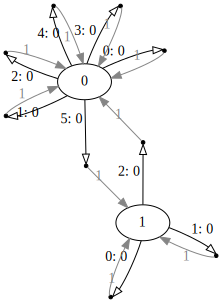

In [27]:
from fimdp.consMDP import ConsMDP

mdp = ConsMDP()
mdp.new_states(2)
mdp.add_action(0, {0 : 1}, "0", 0)
mdp.add_action(0, {0 : 1}, "1", 0)
mdp.add_action(0, {0 : 1}, "2", 0)
mdp.add_action(0, {0 : 1}, "3", 0)
mdp.add_action(0, {0 : 1}, "4", 0)
mdp.add_action(0, {1 : 1}, "5", 0)
mdp.add_action(1, {1 : 1}, "0", 0)
mdp.add_action(1, {1 : 1}, "1", 0)
mdp.add_action(1, {0 : 1}, "2", 0)
mdp

In [28]:
ms = ModStrategy(mdp)
for _ in range(6):
    print(ms.next_action(0))
for _ in range(3):
    print(ms.next_action(1))
for _ in range(3):
    print(ms.next_action(0))

0——0[0]——>{0: 1}
0——1[0]——>{0: 1}
0——2[0]——>{0: 1}
0——3[0]——>{0: 1}
0——4[0]——>{0: 1}
0——5[0]——>{1: 1}
1——0[0]——>{1: 1}
1——1[0]——>{1: 1}
1——2[0]——>{0: 1}
0——3[0]——>{0: 1}
0——4[0]——>{0: 1}
0——5[0]——>{1: 1}
